In [1]:
# Handling paths for importing code
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

# Import split and MSELoss. All descent methods.
from Code.utilities import train_test_split, MSELoss_method, plot_test_results
from Code.descent_methods import *
from Code.neural_network import _beta_init, get_neural_network_model

# Import tools from the first project. Feature matrix, sampling and scaling
from Code.project1_tools import feature_matrix_2d, r2_sampling, scale_feature_matrix

# lines used for nice legend, ticker for x and y axis ticks, seaborn for grid search, pandas for nice datastorage. Numpy. jax jit to speed up
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import pandas as pd
import numpy as np
from jax import jit, grad, nn
from tqdm.notebook import tqdm
from matplotlib.colors import LogNorm


# Timing methods
import time as time

# Import the gradient methods. Assign colors for plots comparing them ...
from Code.utilities import OLS_train_analgrad, OLS_train_autograd, ridge_train_analgrad, ridge_train_autograd, ridge_loss_method

methods_dict_list = [{"name"   : "GD",       "method" : GD,           "color" : "C0"},
                     {"name"   : "SGD",      "method" : SGD,          "color" : "C1"},
                     {"name"   : "adagrad",  "method" : SGD_adagrad,  "color" : "C2"},
                     {"name"   : "RMS prop", "method" : SGD_RMS_prop, "color" : "C3"},
                     {"name"   : "adam",     "method" : SGD_adam,     "color" : "C4"}]

# Set the default font size for text elements (e.g., titles, labels)
sns.set() # default from sns is pretties (:
import matplotlib as mpl
mpl.rcParams['font.size'] = 16  
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['font.family'] = 'sans-serif'

# Set filename start. Create the folder if gone
filepath_location = "Figures/bc/"
if not os.path.exists(filepath_location):
    os.makedirs(filepath_location[0:-1])

In [2]:
### Fix a seed for sampling and initialisation to get consistent results
np.random.seed(41)

# Sample points and split in train and test
num_points = 100
split=0.2
data = r2_sampling(num_points)
x, y, z = data["x"], data["y"], data["z"]

# Features are te coordinates x and y
X = np.array([np.array([x[i][0], y[i][0]]) for i in range(len(x))])
X, means, var = scale_feature_matrix(X)

# Activation functions
activation_funcs = {"ReLu":nn.relu, "Leaky ReLu":nn.leaky_relu, "Sigmoid":nn.sigmoid, "Tanh":nn.tanh}


{'W1': Array([[ 0.00098473, -0.00075503,  0.00262475, -0.00451653,  0.00678104,
        -0.00042137, -0.00110602,  0.00273479, -0.00283256, -0.00041563],
       [-0.00271745,  0.00235779, -0.00814533,  0.01399116, -0.02109023,
         0.00127473,  0.00341025, -0.00864385,  0.00863882,  0.00128641]],      dtype=float32), 'W2': Array([[-0.03123686, -0.03456125,  0.00221826,  0.02594121, -0.02266204,
         0.00423771,  0.01519099,  0.0132127 ,  0.02052051, -0.01771896],
       [-0.04295472, -0.04758409,  0.00305126,  0.03568929, -0.03121197,
         0.00577999,  0.02086597,  0.01822071,  0.02822211, -0.02437651],
       [-0.05455247, -0.06047475,  0.00387597,  0.04534017, -0.03968405,
         0.00730605,  0.02648658,  0.02317822,  0.03584785, -0.03096851],
       [-0.05666287, -0.06281988,  0.00402603,  0.04709634, -0.04122565,
         0.00758391,  0.02750961,  0.02408024,  0.03723561, -0.03216811],
       [-0.03691171, -0.04086818,  0.00262144,  0.03065927, -0.02679244,
         0

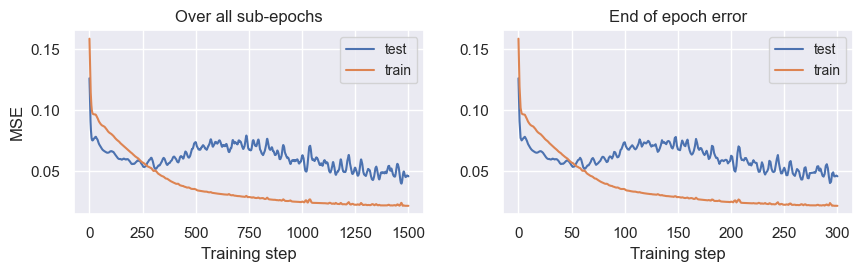

Log run


In [30]:
def single_run(X, y, lr, lam, hidden_layer_num, node_per_hidden, hidden_activation, test_index=None, plot_or_not=False):
    layer_list = [X.shape[1]] + [node_per_hidden]*hidden_layer_num + [1]
    beta0 = _beta_init(layer_list)

    epochs = 300

    model = jit(get_neural_network_model(hidden_layer_num ,activation=hidden_activation))

    loss_func = jit(ridge_loss_method(model=model, lam=lam))
    loss_grad = jit(grad(loss_func))

    test_func = jit(MSELoss_method(model))

    X_train, y_train, X_test, y_test, test_index = train_test_split(X, y, 0.2, test_index=test_index)
    #print(loss_grad(beta0, X_train, y_train))

    result = SGD_adam(X_train, y_train, X_test, y_test, grad_method=loss_grad,beta0=beta0, n_epochs=epochs, test_loss_func=test_func, lr=lr)
    #result = SGD(X_train, y_train, X_test, y_test, grad_method=loss_grad,beta0=beta0, n_epochs=epochs, test_loss_func=test_func, lr=lr)

    result.update({"test_index":test_index, "model":model, "X_test":X_test, "y_test":y_test})

    if plot_or_not:
        plot_test_results(result["test_loss_list"], result["train_loss_list"], 5)


    return result




result = single_run(X, z, lr=1e-3, lam=0.00, hidden_layer_num=2, node_per_hidden=10, hidden_activation=nn.sigmoid, plot_or_not=True)
print("Log run")

In [33]:
def search_lam(savefig=False):
    lr = 0.01
    hidden_layer_num = 2
    node_per_hidden = 5
    
    
    filename = filepath_location + f"lr={lr}_Hidden_layers={hidden_layer_num}_Nodes_per_hidden={node_per_hidden}_lambda_experiment.png"

    lams = np.logspace(-10, 4, num=60)
    test_errs_all = {}
    train_errs_all = {}
    result = {}
    for act_func in activation_funcs.keys():
        test_errs = []
        train_errs = []
        for lam in tqdm(lams):
            #tqdm.write(f"Lambda: {lam}")
            result = single_run(X, z, lr=lr, lam=lam, hidden_layer_num=hidden_layer_num, node_per_hidden=node_per_hidden, hidden_activation=activation_funcs[act_func], test_index=result.get("test_index"))
            test_errs.append(result["test_loss_list"][-1])
            train_errs.append(result["train_loss_list"][-1])
        test_errs_all[act_func] = test_errs
        train_errs_all[act_func] = train_errs

        plt.plot(lams, test_errs, label=act_func)

    plt.legend()
    #plt.plot(lams, train_errs)
    plt.title("Regularization")
    plt.ylabel("Test MSE")
    plt.xlabel("Lambda")
    plt.xscale("log")
    if savefig:
        plt.savefig(filename)  
    plt.show()

    return {"lams":lams, "test_error":test_errs, "train_error":train_errs}

experiment = search_lam(savefig=True)

  0%|          | 0/60 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

KeyboardInterrupt: 

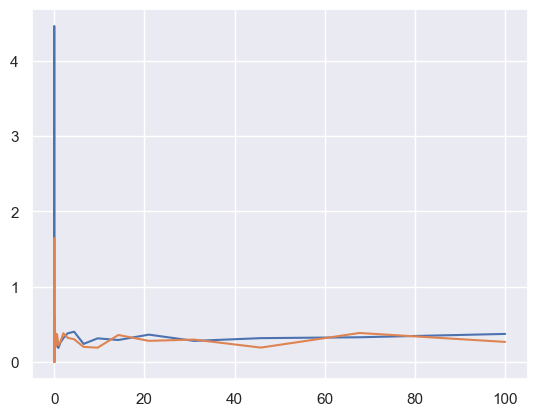

In [ ]:
def search_lrs(savefig=False):
    lam = 0.00
    hidden_layer_num = 3
    node_per_hidden = 5
    
    
    filename = filepath_location + f"lambda={lam}_Hidden_layers={hidden_layer_num}_Nodes_per_hidden={node_per_hidden}_lr_experiment.png"

    lrs = np.logspace(-8, 2, num=60)

    test_errs_all = {}
    train_errs_all = {}
    for act_func in activation_funcs.keys():
        test_errs = []
        train_errs = []
        for lr in tqdm(lrs):
            #tqdm.write(f"Learning rate: {lr}")
            result = single_run(X, z, lr=lr, lam=lam, hidden_layer_num=hidden_layer_num, node_per_hidden=node_per_hidden, hidden_activation=activation_funcs[act_func])
            test_errs.append(result["test_loss_list"][-1])
            train_errs.append(result["train_loss_list"][-1])

        test_errs_all[act_func] = test_errs
        train_errs_all[act_func] = train_errs

        plt.plot(lrs, test_errs, label=act_func)

    plt.plot(lrs, test_errs)

    plt.legend()
    plt.title("Learning rate")
    plt.ylabel("Test MSE")
    plt.xlabel("Learning Rate")
    plt.xscale("log")
    if savefig:
        plt.savefig(filename)  
    plt.show()

    return {"lrs":lrs, "test_error":test_errs, "train_error":train_errs}


#learning_rate_exp = search_lrs()
l = search_lrs(savefig=True)

  0%|          | 0/29 [00:00<?, ?it/s]

Hidden Layer size: 1
Hidden Layer size: 2
Hidden Layer size: 3
Hidden Layer size: 4
Hidden Layer size: 5
Hidden Layer size: 6
Hidden Layer size: 7
Hidden Layer size: 8
Hidden Layer size: 9
Hidden Layer size: 10
Hidden Layer size: 11
Hidden Layer size: 12
Hidden Layer size: 13
Hidden Layer size: 14
Hidden Layer size: 15
Hidden Layer size: 16
Hidden Layer size: 17
Hidden Layer size: 18
Hidden Layer size: 19
Hidden Layer size: 20
Hidden Layer size: 21
Hidden Layer size: 22
Hidden Layer size: 23
Hidden Layer size: 24
Hidden Layer size: 25
Hidden Layer size: 26
Hidden Layer size: 27
Hidden Layer size: 28
Hidden Layer size: 29


  0%|          | 0/29 [00:00<?, ?it/s]

Hidden Layer size: 1
Hidden Layer size: 2
Hidden Layer size: 3
Hidden Layer size: 4
Hidden Layer size: 5
Hidden Layer size: 6
Hidden Layer size: 7
Hidden Layer size: 8
Hidden Layer size: 9
Hidden Layer size: 10
Hidden Layer size: 11
Hidden Layer size: 12
Hidden Layer size: 13
Hidden Layer size: 14
Hidden Layer size: 15
Hidden Layer size: 16
Hidden Layer size: 17
Hidden Layer size: 18
Hidden Layer size: 19
Hidden Layer size: 20
Hidden Layer size: 21
Hidden Layer size: 22
Hidden Layer size: 23
Hidden Layer size: 24
Hidden Layer size: 25
Hidden Layer size: 26
Hidden Layer size: 27
Hidden Layer size: 28
Hidden Layer size: 29


  0%|          | 0/29 [00:00<?, ?it/s]

Hidden Layer size: 1
Hidden Layer size: 2
Hidden Layer size: 3
Hidden Layer size: 4
Hidden Layer size: 5
Hidden Layer size: 6
Hidden Layer size: 7
Hidden Layer size: 8
Hidden Layer size: 9
Hidden Layer size: 10
Hidden Layer size: 11
Hidden Layer size: 12
Hidden Layer size: 13
Hidden Layer size: 14
Hidden Layer size: 15
Hidden Layer size: 16
Hidden Layer size: 17
Hidden Layer size: 18
Hidden Layer size: 19
Hidden Layer size: 20
Hidden Layer size: 21
Hidden Layer size: 22
Hidden Layer size: 23
Hidden Layer size: 24
Hidden Layer size: 25
Hidden Layer size: 26
Hidden Layer size: 27
Hidden Layer size: 28
Hidden Layer size: 29


  0%|          | 0/29 [00:00<?, ?it/s]

Hidden Layer size: 1
Hidden Layer size: 2
Hidden Layer size: 3
Hidden Layer size: 4
Hidden Layer size: 5
Hidden Layer size: 6
Hidden Layer size: 7
Hidden Layer size: 8
Hidden Layer size: 9
Hidden Layer size: 10
Hidden Layer size: 11
Hidden Layer size: 12
Hidden Layer size: 13
Hidden Layer size: 14
Hidden Layer size: 15
Hidden Layer size: 16
Hidden Layer size: 17
Hidden Layer size: 18
Hidden Layer size: 19
Hidden Layer size: 20
Hidden Layer size: 21
Hidden Layer size: 22
Hidden Layer size: 23
Hidden Layer size: 24
Hidden Layer size: 25
Hidden Layer size: 26
Hidden Layer size: 27
Hidden Layer size: 28
Hidden Layer size: 29


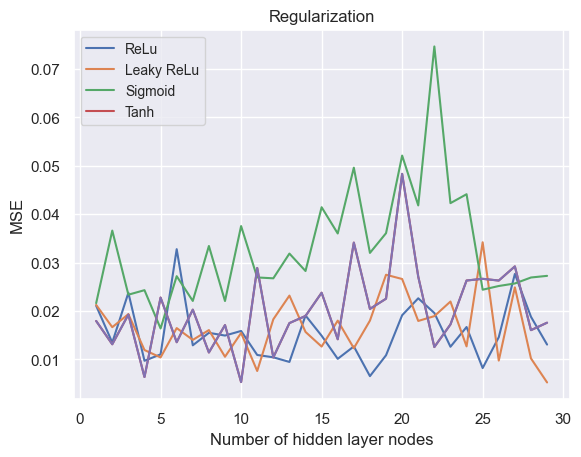

In [ ]:
def search_hidden_layer_sizes(savefig=False):
    lr = 0.01
    lam = 0.01
    hidden_layer_num = 1
    
    
    filename = filepath_location + f"lr={lr}_lambda={lam}_Hidden_layers={hidden_layer_num}_hidden_layer_size_experiment.png"

    hidden_layer_sizes = np.arange(1, 30)

    test_errs_all = {}
    train_errs_all = {}
    for act_func in activation_funcs.keys():
        test_errs = []
        train_errs = []
        for hidden_layer_size in tqdm(hidden_layer_sizes):
            #tqdm.write(f"Hidden Layer size: {hidden_layer_size}")
            result = single_run(X, z, lr=lr, lam=lam, hidden_layer_num=hidden_layer_num, node_per_hidden=hidden_layer_size, hidden_activation=activation_funcs[act_func])
            test_errs.append(result["test_loss_list"][-1])
            train_errs.append(result["train_loss_list"][-1])

        test_errs_all[act_func] = test_errs
        train_errs_all[act_func] = train_errs

        plt.plot(hidden_layer_sizes, test_errs, label=act_func)

    plt.plot(hidden_layer_sizes, test_errs)

    plt.legend()
    plt.title("Model Size")
    plt.ylabel("MSE")
    plt.xlabel("Number of hidden layer nodes")
    if savefig:
        plt.savefig(filename)  
    plt.show()

    return {"hidden_layer_sizes":hidden_layer_sizes, "test_error":test_errs, "train_error":train_errs}


#learning_rate_exp = search_lrs()
l = search_hidden_layer_sizes(savefig=True)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

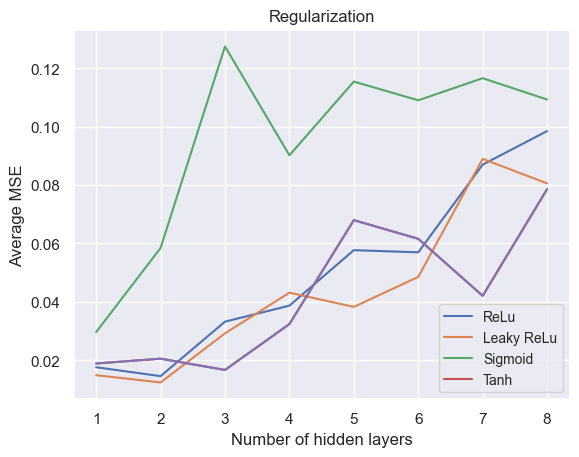

In [ ]:

def search_hidden_layer_number(savefig=False):
    lr = 0.01
    lam = 0.01
    node_per_hidden = 5
    
    
    filename = filepath_location + f"lr={lr}_lambda={lam}_Nodes_per_hidden={node_per_hidden}_hidden_layer_number_experiment.png"

    hidden_layer_numbers = np.arange(1, 9)

    test_errs_all = {}
    train_errs_all = {}
    for act_func in activation_funcs.keys():
        test_errs = []
        train_errs = []
        for hidden_layer_number in tqdm(hidden_layer_numbers):
            #tqdm.write(f"Hidden Layer number: {hidden_layer_number}")
            s_test = 0.0
            s_train = 0.0
            for i in range(10):
                result = single_run(X, z, lr=lr, lam=lam, hidden_layer_num=hidden_layer_number, node_per_hidden=node_per_hidden, hidden_activation=activation_funcs[act_func])
                s_test += result["test_loss_list"][-1]
                s_train += result["train_loss_list"][-1]

            test_errs.append(s_test/10)
            train_errs.append(s_train/10)

        test_errs_all[act_func] = test_errs
        train_errs_all[act_func] = train_errs
        
        plt.plot(hidden_layer_numbers, train_errs, label=act_func)
        plt.plot(hidden_layer_numbers, test_errs, label=f"{act_func} train", linestyle="--")

    plt.legend()
    plt.title("Model Size")
    plt.ylabel("Average MSE")
    plt.xlabel("Number of hidden layers")
    if savefig:
        plt.savefig(filename)  
    plt.show()

    return {"hidden_layer_sizes":hidden_layer_numbers, "test_error":test_errs_all, "train_error":train_errs_all}


#learning_rate_exp = search_lrs()
l = search_hidden_layer_number(savefig=True)

Learning rate: 1e-06, Hidden Layer number: 1
Learning rate: 1e-06, Hidden Layer number: 2
Learning rate: 1e-06, Hidden Layer number: 3
Learning rate: 1e-06, Hidden Layer number: 4
Learning rate: 1e-06, Hidden Layer number: 5
Learning rate: 1e-06, Hidden Layer number: 6
Learning rate: 2.5118864315095822e-05, Hidden Layer number: 1
Learning rate: 2.5118864315095822e-05, Hidden Layer number: 2
Learning rate: 2.5118864315095822e-05, Hidden Layer number: 3
Learning rate: 2.5118864315095822e-05, Hidden Layer number: 4
Learning rate: 2.5118864315095822e-05, Hidden Layer number: 5
Learning rate: 2.5118864315095822e-05, Hidden Layer number: 6
Learning rate: 0.000630957344480193, Hidden Layer number: 1
Learning rate: 0.000630957344480193, Hidden Layer number: 2
Learning rate: 0.000630957344480193, Hidden Layer number: 3
Learning rate: 0.000630957344480193, Hidden Layer number: 4
Learning rate: 0.000630957344480193, Hidden Layer number: 5
Learning rate: 0.000630957344480193, Hidden Layer number: 

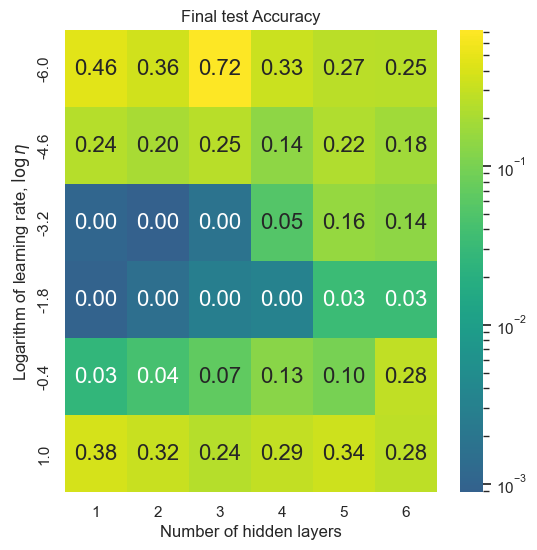

In [ ]:
def learning_rate_hidden_layer_grid(savefig=False):
    lam = 0.01
    node_per_hidden = 5
    hidden_activation = nn.tanh
    hidden_activation_name = "tanh"
    
    
    filename = filepath_location + f"lambda={lam}_Nodes_per_hidden={node_per_hidden}_hidden_activation_func={hidden_activation_name}__lr_hidden_layer_num_grid_experiment.png"

    hidden_layer_numbers = np.arange(1, 7)
    lrs = np.logspace(-6, 1, 6)

    test_errs_all = np.zeros(shape=(6, 6))
    train_errs_all = np.zeros(shape=(6, 6))
    for i, lr in enumerate(lrs):
        for j, hidden_layer_number in enumerate(hidden_layer_numbers):
            #tqdm.write(f"Learning rate: {lr}, Hidden Layer number: {hidden_layer_number}")
            s_test = 0.0
            s_train = 0.0
            for k in range(5):
                result = single_run(X, y, lr=lr, lam=lam, hidden_layer_num=hidden_layer_number, node_per_hidden=node_per_hidden, hidden_activation=hidden_activation)
                s_test += result["test_loss_list"][-1]
                s_train += result["train_loss_list"][-1]

            test_errs_all[i, j] = s_test/5
            train_errs_all[i, j] = s_train/5


    # Make sns heatmap
    fig, ax = plt.subplots(figsize = (6, 6))
    sns.heatmap(test_errs_all, annot=True, ax=ax, cmap="viridis", center=0.2, cbar=True, norm="log", fmt=".2f")

    # Title
    ax.set_title("Final test Accuracy")

    # Handle labels
    ax.set_xlabel("Number of hidden layers")
    ax.set_ylabel("Logarithm of learning rate, $\log{\eta}$")

    ax.set_yticklabels(np.round(np.log10(lrs), 2))
    ax.set_xticklabels((hidden_layer_numbers))

    if savefig:
        fig.savefig(filename)

    plt.show()

    return {"hidden_layer_sizes":hidden_layer_numbers, "test_error":test_errs_all, "train_error":train_errs_all}


r= learning_rate_hidden_layer_grid(savefig=True)